In [1]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader, Subset
from utils.data import COCOAEDataset, collate_fn
from utils.transforms import get_transform
from utils.transforms import ResizeTransform
from noise.scheduler import NoiseScheduler, LinearMaskScheduler, mask_image
from models.masked_autoencoder import MaskedAEConfig, MaskedAutoEncoderForPretraining
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

c:\Users\Rodrigo\.conda\envs\dl-final-sp2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = COCOAEDataset(root="coco/images/train2017/",
                        annFile="coco/annotations/ann2017/captions_train2017.json",
                        transform=get_transform(),
                        tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased', cache_dir='cache/'),
                        ignore_cache=False,
                        train=True)

# Tiny tiny subset of this dataset to see if we can overfit
dataset = Subset(dataset, range(2))

Loading cached annotations...


In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        collate_fn=collate_fn(dataset.dataset.tokenizer.pad_token_id),
                        pin_memory=True)

noise_scheduler = LinearMaskScheduler(vocab_size=len(dataset.dataset.tokenizer), device=DEVICE)
model = MaskedAutoEncoderForPretraining(MaskedAEConfig(len(dataset.dataset.tokenizer))).to(DEVICE)

c:\Users\Rodrigo\.conda\envs\dl-final-sp2024\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
optim = torch.optim.Adam(model.parameters(), lr=4e-5)
image_loss = torch.nn.MSELoss()
caption_loss = torch.nn.CrossEntropyLoss()

In [12]:
for epoch in (pbar := tqdm(range(1000))):
    for images, captions in dataloader:
        optim.zero_grad()
        images = images.to(DEVICE, non_blocking=True)
        captions = captions.to(DEVICE, non_blocking=True)

        masked_images, masked_text, (ip, rp, tm) = noise_scheduler.get_masked(images, captions, need_masks=True)
        reconstructed_images, reconstructed_captions = model.forward(masked_images, masked_text, ip, rp)

        rec_loss = image_loss(reconstructed_images, images)
        cap_loss = caption_loss(reconstructed_captions.permute(0, 2, 1), captions)
        pbar.set_description(f"Image Loss : {rec_loss.item():1.3} | Caption Loss : {cap_loss.item():1.3}")
        (rec_loss + cap_loss).backward()
        # print(model.ite.weight.grad)
        optim.step()
        
    


Image Loss : 0.00888 | Caption Loss : 0.395: 100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]


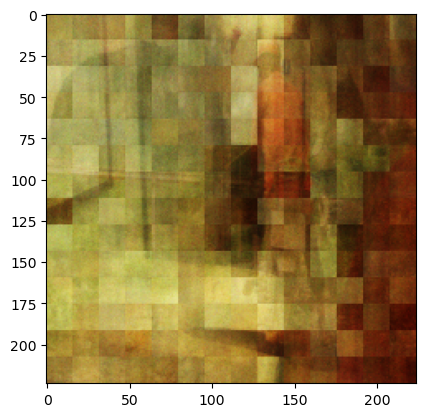

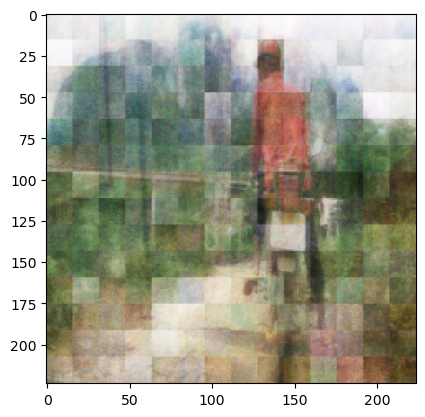

[CLS] a woman wearing a that is cutting a white cake cake [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud - wreathed mountains. [SEP]


In [13]:
for image in reconstructed_images:
    plt.imshow(image.permute(1, 2, 0).detach().cpu().numpy())
    plt.show()

for caption in reconstructed_captions:
    print(dataset.dataset.tokenizer.decode(torch.argmax(caption, dim=-1)))